<a href="https://colab.research.google.com/github/navaneethakannanindia7/Privacy-Preserving-Customer-churn-Prediction-using-Federated-Learning-on-distributed-Data/blob/main/federated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#imports for federated learning
import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("="*60)
print("PHASE 2: FEDERATED LEARNING IMPLEMENTATION")
print("="*60)
print("\nSimulating 3 telecom companies collaborating without sharing data")

PHASE 2: FEDERATED LEARNING IMPLEMENTATION

Simulating 3 telecom companies collaborating without sharing data


In [ ]:
# Reload the original dataset (before train/test split)
# We'll create a fresh split for federated learning
import pandas as pd
import numpy as np

# Load dataset
df_fed = pd.read_csv('churn.csv')  # Use your actual filename

print(f"Total dataset size: {len(df_fed)} customers")
print(f"Churn distribution: \n{df_fed['Churn'].value_counts()}")

# Apply the same preprocessing we did before
# (You can copy-paste from your preprocessing cells, or I'll provide a compact version)

Total dataset size: 7043 customers
Churn distribution: 
Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [25]:
def preprocess_data(df):
    """
    Apply all preprocessing steps to the dataframe
    Returns: X (features), y (target)
    """
    df = df.copy()

    # Handle TotalCharges
    if 'TotalCharges' in df.columns:
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
        df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

    # Handle other missing values
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            if df[column].dtype == 'object':
                df[column].fillna(df[column].mode()[0], inplace=True)
            else:
                df[column].fillna(df[column].median(), inplace=True)

    # Convert Churn to binary
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    # Drop customerID
    if 'customerID' in df.columns:
        df.drop('customerID', axis=1, inplace=True)

    # Identify categorical and numerical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Encode binary categorical variables
    binary_cols = []
    for col in categorical_cols:
        if df[col].nunique() == 2:
            binary_cols.append(col)
            df[col] = df[col].map({df[col].unique()[0]: 0, df[col].unique()[1]: 1})

    # One-hot encode remaining categorical variables
    remaining_categorical = [col for col in categorical_cols if col not in binary_cols]
    if remaining_categorical:
        df = pd.get_dummies(df, columns=remaining_categorical, drop_first=True)

    # Separate features and target
    X = df.drop('Churn', axis=1)
    y = df['Churn']

    return X, y

# Test the preprocessing
X_full, y_full = preprocess_data(df_fed)
print(f"\nPreprocessed dataset shape: {X_full.shape}")
print(f"Number of features: {X_full.shape[1]}")
print(f"Target distribution: {y_full.value_counts().to_dict()}")

/tmp/ipython-input-603/109866368.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)



Preprocessed dataset shape: (7043, 30)
Number of features: 30
Target distribution: {0: 5174, 1: 1869}


In [26]:
# Create a global test set that all clients will use for evaluation
from sklearn.model_selection import train_test_split

X_train_global, X_test_global, y_train_global, y_test_global = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

print(f"Global training set: {X_train_global.shape}")
print(f"Global test set: {X_test_global.shape}")
print(f"\nTraining set churn distribution:")
print(y_train_global.value_counts(normalize=True))

Global training set: (5634, 30)
Global test set: (1409, 30)

Training set churn distribution:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64


In [28]:
def partition_data_non_iid(X, y, n_clients=3, random_state=42):
    """
    Partition data into n_clients with Non-IID distribution
    Each client gets different proportions of churned vs non-churned customers
    Simulates real-world scenario where different companies have different churn rates
    """
    np.random.seed(random_state)

    # Separate churned and non-churned customers
    churn_indices = y[y == 1].index.tolist()
    no_churn_indices = y[y == 0].index.tolist()

    # Shuffle
    np.random.shuffle(churn_indices)
    np.random.shuffle(no_churn_indices)

    # Create different churn ratios for each client
    # Client 0: Higher churn rate (aggressive market)
    # Client 1: Medium churn rate (balanced)
    # Client 2: Lower churn rate (stable market)

    churn_ratios = [0.4, 0.3, 0.3]  # How to distribute churned customers
    no_churn_ratios = [0.3, 0.35, 0.35]  # How to distribute non-churned customers

    client_data = []

    churn_start = 0
    no_churn_start = 0

    for i in range(n_clients):
        # Calculate how many churned customers this client gets
        n_churn = int(len(churn_indices) * churn_ratios[i])
        n_no_churn = int(len(no_churn_indices) * no_churn_ratios[i])

        # Get indices for this client
        client_churn_idx = churn_indices[churn_start:churn_start + n_churn]
        client_no_churn_idx = no_churn_indices[no_churn_start:no_churn_start + n_no_churn]

        # Combine indices
        client_indices = client_churn_idx + client_no_churn_idx
        np.random.shuffle(client_indices)

        # Extract data for this client
        X_client = X.loc[client_indices]
        y_client = y.loc[client_indices]

        client_data.append({
            'X': X_client,
            'y': y_client,
            'client_id': i
        })

        # Update starting positions
        churn_start += n_churn
        no_churn_start += n_no_churn

        # Print client statistics
        churn_rate = (y_client == 1).sum() / len(y_client) * 100
        print(f"\nClient {i}:")
        print(f"  Total samples: {len(y_client)}")
        print(f"  Churned: {(y_client == 1).sum()} ({churn_rate:.1f}%)")
        print(f"  Not Churned: {(y_client == 0).sum()} ({100-churn_rate:.1f}%)")

    return client_data

# Partition the training data
clients = partition_data_non_iid(X_train_global, y_train_global, n_clients=3)

print("\n" + "="*60)
print("✓ Data partitioned into 3 clients with Non-IID distribution")
print("="*60)


Client 0:
  Total samples: 1839
  Churned: 598 (32.5%)
  Not Churned: 1241 (67.5%)

Client 1:
  Total samples: 1896
  Churned: 448 (23.6%)
  Not Churned: 1448 (76.4%)

Client 2:
  Total samples: 1896
  Churned: 448 (23.6%)
  Not Churned: 1448 (76.4%)

✓ Data partitioned into 3 clients with Non-IID distribution


In [29]:
from sklearn.preprocessing import StandardScaler

# Scale data for each client independently
# (In real federated learning, each client scales their own data)

scalers = []
for i, client in enumerate(clients):
    scaler = StandardScaler()
    clients[i]['X_scaled'] = scaler.fit_transform(client['X'])
    scalers.append(scaler)
    print(f"✓ Client {i} data scaled")

# Scale the global test set using the first client's scaler
# (Or you could use a global scaler - both approaches are valid)
test_scaler = StandardScaler()
X_test_scaled_global = test_scaler.fit_transform(X_test_global)

print("\n✓ All data scaled and ready for training")

✓ Client 0 data scaled
✓ Client 1 data scaled
✓ Client 2 data scaled

✓ All data scaled and ready for training


In [30]:
from sklearn.linear_model import LogisticRegression

def train_local_model(X_train, y_train, client_id):
    """
    Train a logistic regression model on local client data
    """
    model = LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced',
        solver='lbfgs'
    )

    model.fit(X_train, y_train)

    # Evaluate on local data
    y_pred = model.predict(X_train)
    accuracy = accuracy_score(y_train, y_pred)

    print(f"Client {client_id} - Local Training Accuracy: {accuracy:.4f}")

    return model

# Train local models
print("="*60)
print("TRAINING LOCAL MODELS (Each client trains independently)")
print("="*60)

local_models = []
for i, client in enumerate(clients):
    print(f"\nTraining Client {i}...")
    model = train_local_model(client['X_scaled'], client['y'], i)
    local_models.append(model)
    clients[i]['model'] = model

print("\n✓ All local models trained")

TRAINING LOCAL MODELS (Each client trains independently)

Training Client 0...
Client 0 - Local Training Accuracy: 0.7602

Training Client 1...
Client 1 - Local Training Accuracy: 0.7558

Training Client 2...
Client 2 - Local Training Accuracy: 0.7384

✓ All local models trained


In [31]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Evaluate a model and return metrics
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba)
    }

    return metrics

# Evaluate each local model
print("="*60)
print("EVALUATING LOCAL MODELS ON GLOBAL TEST SET")
print("="*60)

local_results = []
for i, model in enumerate(local_models):
    metrics = evaluate_model(model, X_test_scaled_global, y_test_global, f"Client {i}")
    local_results.append(metrics)

    print(f"\nClient {i} Performance:")
    for key, value in metrics.items():
        if key != 'Model':
            print(f"  {key}: {value:.4f}")

# Create comparison dataframe
local_results_df = pd.DataFrame(local_results)
print("\n" + "="*60)
print("LOCAL MODELS COMPARISON")
print("="*60)
print(local_results_df.to_string(index=False))

EVALUATING LOCAL MODELS ON GLOBAL TEST SET

Client 0 Performance:
  Accuracy: 0.7239
  Precision: 0.4879
  Recall: 0.8102
  F1-Score: 0.6090
  AUC: 0.8341

Client 1 Performance:
  Accuracy: 0.7402
  Precision: 0.5071
  Recall: 0.7594
  F1-Score: 0.6081
  AUC: 0.8396

Client 2 Performance:
  Accuracy: 0.7339
  Precision: 0.4991
  Recall: 0.7834
  F1-Score: 0.6098
  AUC: 0.8379

LOCAL MODELS COMPARISON
   Model  Accuracy  Precision   Recall  F1-Score      AUC
Client 0  0.723918   0.487923 0.810160  0.609045 0.834070
Client 1  0.740241   0.507143 0.759358  0.608137 0.839619
Client 2  0.733854   0.499148 0.783422  0.609781 0.837859


In [32]:
def federated_averaging(local_models, client_weights=None):
    """
    Aggregate local models using Federated Averaging (FedAvg)

    Parameters:
    - local_models: List of trained sklearn models
    - client_weights: Optional weights for each client (based on data size)
                     If None, equal weights are used

    Returns:
    - global_model: Aggregated model
    """
    n_clients = len(local_models)

    # If no weights provided, use equal weights
    if client_weights is None:
        client_weights = [1/n_clients] * n_clients

    # Normalize weights to sum to 1
    total_weight = sum(client_weights)
    client_weights = [w/total_weight for w in client_weights]

    # Initialize global model
    global_model = LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced',
        solver='lbfgs'
    )

    # We need to initialize the global model first
    # Use the first client's data structure (doesn't matter which)
    global_model.fit(clients[0]['X_scaled'][:10], clients[0]['y'][:10])

    # Average the coefficients (weights)
    avg_coef = np.zeros_like(local_models[0].coef_)
    avg_intercept = np.zeros_like(local_models[0].intercept_)

    for i, model in enumerate(local_models):
        avg_coef += client_weights[i] * model.coef_
        avg_intercept += client_weights[i] * model.intercept_

    # Set the averaged parameters to global model
    global_model.coef_ = avg_coef
    global_model.intercept_ = avg_intercept

    print("="*60)
    print("FEDERATED AVERAGING COMPLETED")
    print("="*60)
    print(f"Aggregated {n_clients} local models")
    print(f"Client weights: {[f'{w:.3f}' for w in client_weights]}")

    return global_model

# Calculate client weights based on their data sizes
client_sizes = [len(client['y']) for client in clients]
client_weights = [size/sum(client_sizes) for size in client_sizes]

print("Client data sizes:", client_sizes)
print("Client weights:", [f"{w:.3f}" for w in client_weights])

# Perform federated averaging
global_federated_model = federated_averaging(local_models, client_weights)

print("\n✓ Global federated model created")

Client data sizes: [1839, 1896, 1896]
Client weights: ['0.327', '0.337', '0.337']
FEDERATED AVERAGING COMPLETED
Aggregated 3 local models
Client weights: ['0.327', '0.337', '0.337']

✓ Global federated model created


DETAILED CLIENT-BY-CLIENT TRAINING DATA ANALYSIS

CLIENT TRAINING DATA SUMMARY
  Client  Total_Samples  Churned  Not_Churned  Churn_Rate_%  Features
Client 0           1839      598         1241         32.52        30
Client 1           1896      448         1448         23.63        30
Client 2           1896      448         1448         23.63        30

OVERALL TRAINING DATA STATISTICS
Total Training Samples Across All Clients: 5631
Total Churned: 1494 (26.53%)
Total Not Churned: 4137 (73.47%)

FEATURE STATISTICS BY CLIENT

CLIENT 0 - FEATURE STATISTICS

Top 10 Features by Mean Value:
                         mean          std   min     max
TotalCharges      2193.897662  2230.726739  19.0  8684.8
MonthlyCharges      66.430479    29.184443  18.4   118.6
tenure              30.464927    24.475471   0.0    72.0
PhoneService         0.904840     0.293516   0.0     1.0
Partner              0.530179     0.499224   0.0     1.0
gender               0.519848     0.499742   0.0     1.0
Paper

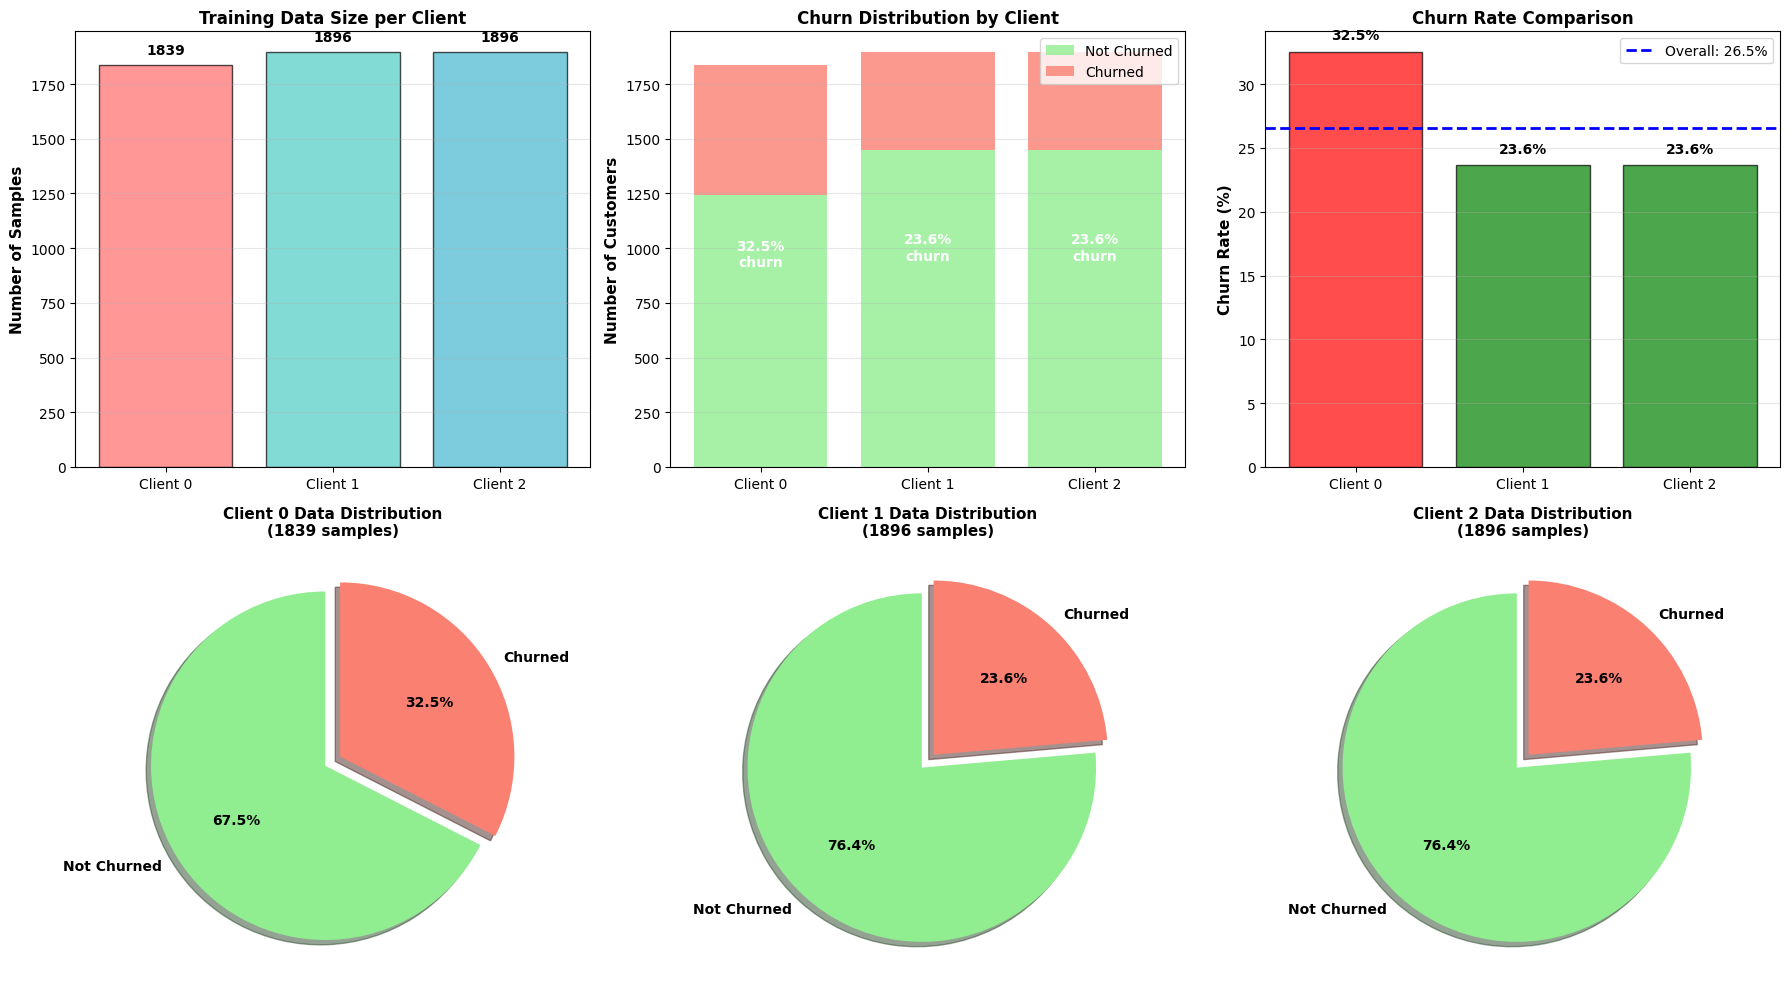


✓ Client training data visualization saved: client_training_data_analysis.png
✓ Client training data summary saved: client_training_data_summary.csv
✓ Client 0 feature details saved: client_0_training_features.csv
✓ Client 1 feature details saved: client_1_training_features.csv
✓ Client 2 feature details saved: client_2_training_features.csv

✅ DETAILED CLIENT TRAINING DATA ANALYSIS COMPLETE


In [33]:
print("="*80)
print("DETAILED CLIENT-BY-CLIENT TRAINING DATA ANALYSIS")
print("="*80)

# ============================================================
# 1. COMPREHENSIVE CLIENT DATA SUMMARY
# ============================================================

client_detailed_info = []

for i, client in enumerate(clients):
    X_client = client['X']
    y_client = client['y']
    X_scaled = client['X_scaled']

    # Basic statistics
    total_samples = len(y_client)
    n_churned = (y_client == 1).sum()
    n_not_churned = (y_client == 0).sum()
    churn_rate = (n_churned / total_samples) * 100

    # Feature statistics
    n_features = X_client.shape[1]

    client_info = {
        'Client': f'Client {i}',
        'Total_Samples': total_samples,
        'Churned': n_churned,
        'Not_Churned': n_not_churned,
        'Churn_Rate_%': round(churn_rate, 2),
        'Features': n_features
    }
    client_detailed_info.append(client_info)

# Create summary DataFrame
client_summary_df = pd.DataFrame(client_detailed_info)

print("\n" + "="*80)
print("CLIENT TRAINING DATA SUMMARY")
print("="*80)
print(client_summary_df.to_string(index=False))

# Calculate totals
total_samples_all = client_summary_df['Total_Samples'].sum()
total_churned_all = client_summary_df['Churned'].sum()
total_not_churned_all = client_summary_df['Not_Churned'].sum()
overall_churn_rate = (total_churned_all / total_samples_all) * 100

print("\n" + "="*80)
print("OVERALL TRAINING DATA STATISTICS")
print("="*80)
print(f"Total Training Samples Across All Clients: {total_samples_all}")
print(f"Total Churned: {total_churned_all} ({overall_churn_rate:.2f}%)")
print(f"Total Not Churned: {total_not_churned_all} ({100-overall_churn_rate:.2f}%)")

# ============================================================
# 2. DETAILED FEATURE STATISTICS PER CLIENT
# ============================================================

print("\n" + "="*80)
print("FEATURE STATISTICS BY CLIENT")
print("="*80)

for i, client in enumerate(clients):
    X_client = client['X']

    print(f"\n{'='*80}")
    print(f"CLIENT {i} - FEATURE STATISTICS")
    print(f"{'='*80}")

    # Get statistics for numerical features
    feature_stats = X_client.describe().T
    feature_stats = feature_stats[['mean', 'std', 'min', 'max']]

    print("\nTop 10 Features by Mean Value:")
    print(feature_stats.sort_values('mean', ascending=False).head(10).to_string())

    # Show some sample data
    print(f"\nSample Data (First 5 rows):")
    print(X_client.head().to_string())

# ============================================================
# 3. CLIENT DATA DISTRIBUTION VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Sample Size Distribution
client_names = [f'Client {i}' for i in range(len(clients))]
sample_sizes = [len(c['y']) for c in clients]
colors_samples = ['#FF6B6B', '#4ECDC4', '#45B7D1']

axes[0, 0].bar(client_names, sample_sizes, color=colors_samples, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Training Data Size per Client', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(sample_sizes):
    axes[0, 0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Plot 2: Churn Distribution
churned_counts = [int((c['y'] == 1).sum()) for c in clients]
not_churned_counts = [int((c['y'] == 0).sum()) for c in clients]

x_pos = np.arange(len(client_names))
axes[0, 1].bar(x_pos, not_churned_counts, label='Not Churned', color='lightgreen', alpha=0.8)
axes[0, 1].bar(x_pos, churned_counts, bottom=not_churned_counts, label='Churned', color='salmon', alpha=0.8)
axes[0, 1].set_ylabel('Number of Customers', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Churn Distribution by Client', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(client_names)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Add churn rate labels
for i, (churn, no_churn) in enumerate(zip(churned_counts, not_churned_counts)):
    total = churn + no_churn
    churn_pct = churn / total * 100
    axes[0, 1].text(i, total/2, f'{churn_pct:.1f}%\nchurn', ha='center', fontweight='bold', color='white')

# Plot 3: Churn Rate Comparison
churn_rates = [(c['y'] == 1).sum() / len(c['y']) * 100 for c in clients]
colors_churn = ['red' if rate > 30 else 'orange' if rate > 25 else 'green' for rate in churn_rates]

axes[0, 2].bar(client_names, churn_rates, color=colors_churn, alpha=0.7, edgecolor='black')
axes[0, 2].set_ylabel('Churn Rate (%)', fontsize=11, fontweight='bold')
axes[0, 2].set_title('Churn Rate Comparison', fontsize=12, fontweight='bold')
axes[0, 2].axhline(y=overall_churn_rate, color='blue', linestyle='--', linewidth=2, label=f'Overall: {overall_churn_rate:.1f}%')
axes[0, 2].legend()
axes[0, 2].grid(axis='y', alpha=0.3)
for i, v in enumerate(churn_rates):
    axes[0, 2].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# Plot 4: Data Distribution (Pie Charts for each client)
for idx, (i, client) in enumerate(enumerate(clients)):
    row = 1
    col = idx

    churned = int((client['y'] == 1).sum())
    not_churned = int((client['y'] == 0).sum())

    sizes = [not_churned, churned]
    labels = ['Not Churned', 'Churned']
    colors_pie = ['lightgreen', 'salmon']
    explode = (0.05, 0.05)

    axes[row, col].pie(sizes, explode=explode, labels=labels, colors=colors_pie,
                       autopct='%1.1f%%', shadow=True, startangle=90,
                       textprops={'fontweight': 'bold'})
    axes[row, col].set_title(f'Client {i} Data Distribution\n({len(client["y"])} samples)',
                            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('client_training_data_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Client training data visualization saved: client_training_data_analysis.png")

# ============================================================
# 4. SAVE CLIENT TRAINING DATA DETAILS
# ============================================================

# Save summary to CSV
client_summary_df.to_csv('client_training_data_summary.csv', index=False)
print("✓ Client training data summary saved: client_training_data_summary.csv")

# Create detailed report for each client
for i, client in enumerate(clients):
    client_detail_df = pd.DataFrame({
        'Feature': client['X'].columns,
        'Mean': client['X'].mean(),
        'Std': client['X'].std(),
        'Min': client['X'].min(),
        'Max': client['X'].max()
    })
    client_detail_df.to_csv(f'client_{i}_training_features.csv', index=False)
    print(f"✓ Client {i} feature details saved: client_{i}_training_features.csv")

print("\n" + "="*80)
print("✅ DETAILED CLIENT TRAINING DATA ANALYSIS COMPLETE")
print("="*80)

DETAILED CLIENT-BY-CLIENT TESTING PERFORMANCE

CLIENT 0 - TESTING PERFORMANCE

Training Data:
  • Samples: 1839
  • Churn Rate: 32.52%

Test Performance:
  • Accuracy:  0.7239
  • Precision: 0.4879
  • Recall:    0.8102
  • F1-Score:  0.6090
  • AUC:       0.8341

Confusion Matrix:
[[717 318]
 [ 71 303]]
  • True Positives:  303
  • True Negatives:  717
  • False Positives: 318
  • False Negatives: 71

Detailed Classification Report:
              precision    recall  f1-score   support

   Not Churn     0.9099    0.6928    0.7866      1035
       Churn     0.4879    0.8102    0.6090       374

    accuracy                         0.7239      1409
   macro avg     0.6989    0.7515    0.6978      1409
weighted avg     0.7979    0.7239    0.7395      1409


CLIENT 1 - TESTING PERFORMANCE

Training Data:
  • Samples: 1896
  • Churn Rate: 23.63%

Test Performance:
  • Accuracy:  0.7402
  • Precision: 0.5071
  • Recall:    0.7594
  • F1-Score:  0.6081
  • AUC:       0.8396

Confusion Matrix

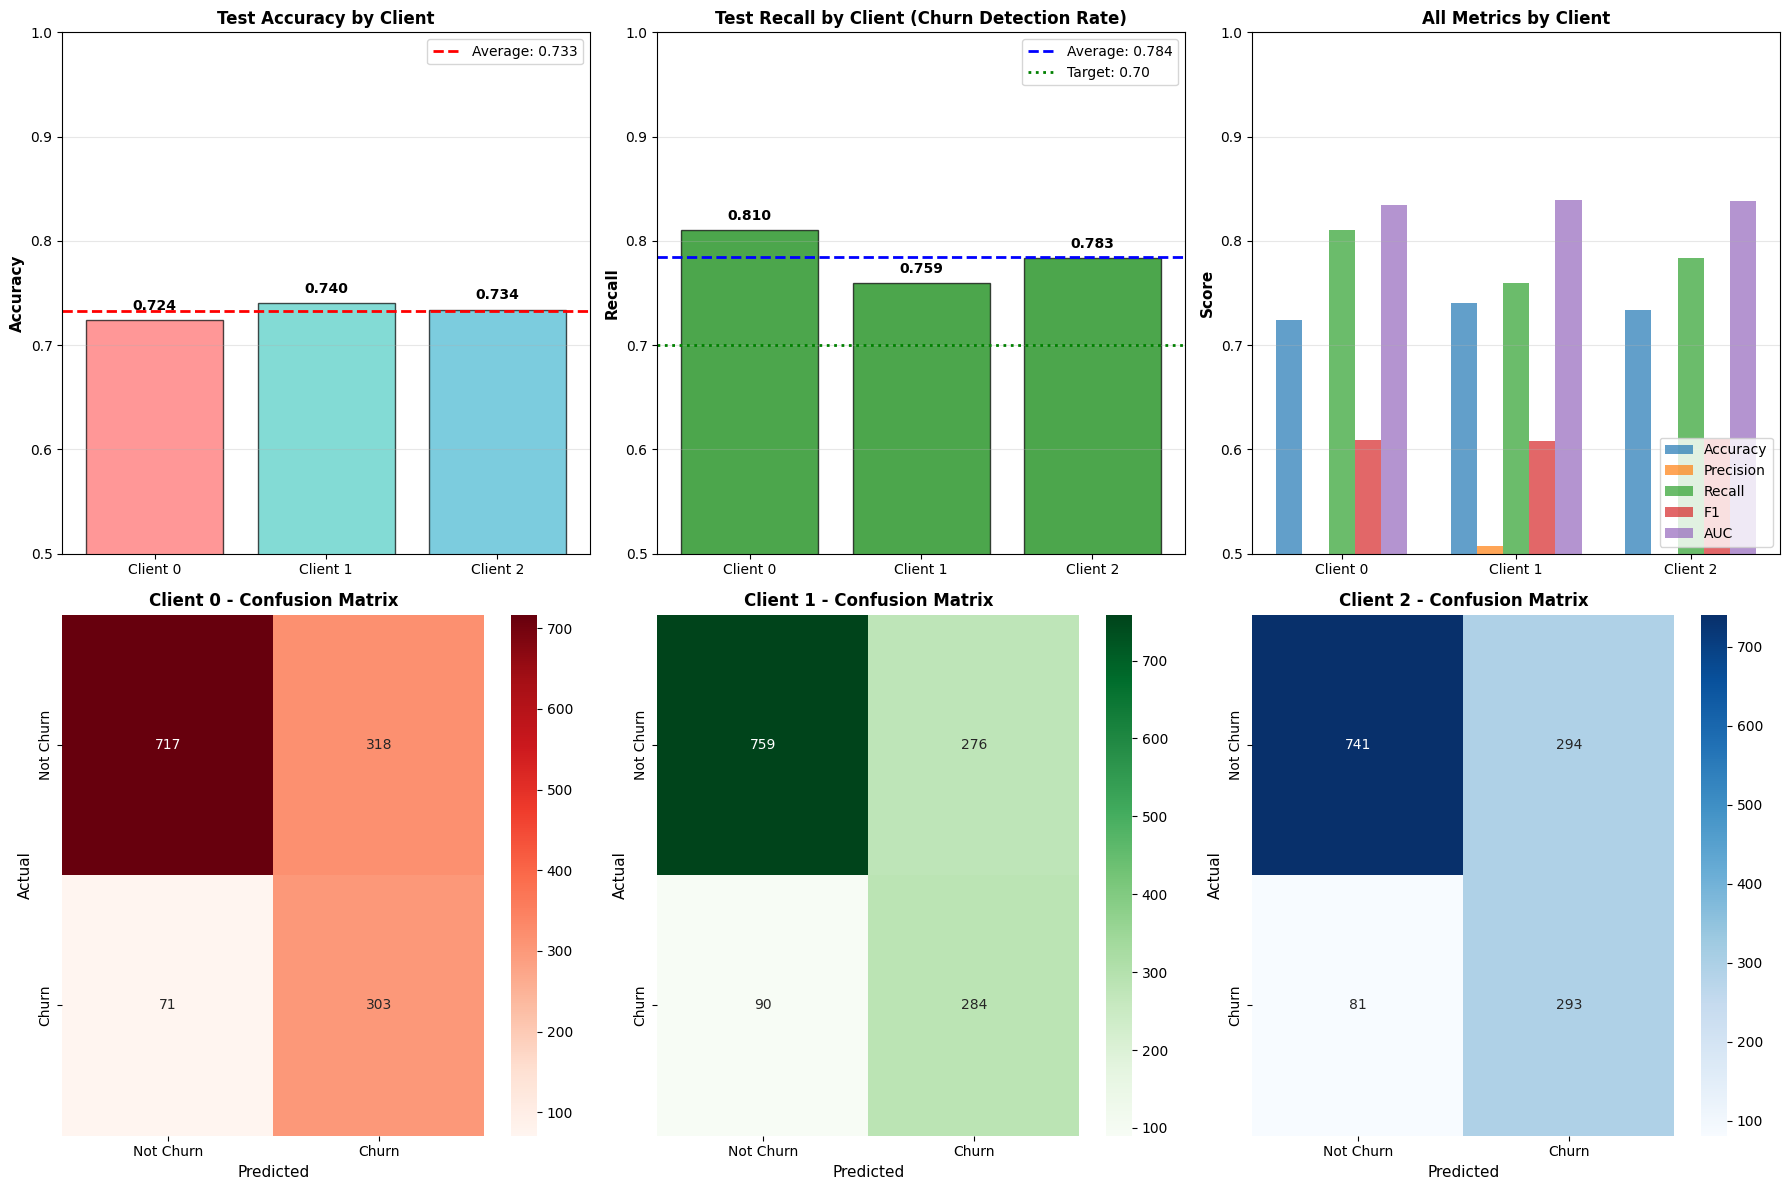


✓ Client testing performance visualization saved: client_testing_performance_detailed.png

PERFORMANCE INSIGHTS

🏆 Best Performing Client: Client 1
   • Accuracy: 0.7402
   • Recall: 0.7594
   • Training samples: 1896

⚠ Weakest Performing Client: Client 0
   • Accuracy: 0.7239
   • Recall: 0.8102
   • Training samples: 1839

📊 Performance Gap: 0.0163 (1.63%)

🔗 Correlation between training size and accuracy: 0.924
   → Strong positive correlation: More data leads to better performance

✓ Client testing performance saved: client_testing_performance_detailed.csv
✓ Client 0 predictions saved: client_0_test_predictions.csv
✓ Client 1 predictions saved: client_1_test_predictions.csv
✓ Client 2 predictions saved: client_2_test_predictions.csv

✅ DETAILED CLIENT TESTING ANALYSIS COMPLETE


In [34]:
print("="*80)
print("DETAILED CLIENT-BY-CLIENT TESTING PERFORMANCE")
print("="*80)

# ============================================================
# 1. TEST EACH LOCAL MODEL ON GLOBAL TEST SET
# ============================================================

client_test_results = []

for i, (client, model) in enumerate(zip(clients, local_models)):
    print(f"\n{'='*80}")
    print(f"CLIENT {i} - TESTING PERFORMANCE")
    print(f"{'='*80}")

    # Make predictions
    y_pred = model.predict(X_test_scaled_global)
    y_pred_proba = model.predict_proba(X_test_scaled_global)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test_global, y_pred)
    precision = precision_score(y_test_global, y_pred)
    recall = recall_score(y_test_global, y_pred)
    f1 = f1_score(y_test_global, y_pred)
    auc = roc_auc_score(y_test_global, y_pred_proba)

    # Confusion matrix
    cm = confusion_matrix(y_test_global, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Store results
    client_test_results.append({
        'Client': f'Client {i}',
        'Training_Samples': len(client['y']),
        'Training_Churn_Rate_%': round((client['y'] == 1).sum() / len(client['y']) * 100, 2),
        'Test_Accuracy': round(accuracy, 4),
        'Test_Precision': round(precision, 4),
        'Test_Recall': round(recall, 4),
        'Test_F1': round(f1, 4),
        'Test_AUC': round(auc, 4),
        'True_Positives': int(tp),
        'True_Negatives': int(tn),
        'False_Positives': int(fp),
        'False_Negatives': int(fn)
    })

    # Print detailed results
    print(f"\nTraining Data:")
    print(f"  • Samples: {len(client['y'])}")
    print(f"  • Churn Rate: {(client['y'] == 1).sum() / len(client['y']) * 100:.2f}%")

    print(f"\nTest Performance:")
    print(f"  • Accuracy:  {accuracy:.4f}")
    print(f"  • Precision: {precision:.4f}")
    print(f"  • Recall:    {recall:.4f}")
    print(f"  • F1-Score:  {f1:.4f}")
    print(f"  • AUC:       {auc:.4f}")

    print(f"\nConfusion Matrix:")
    print(cm)
    print(f"  • True Positives:  {tp}")
    print(f"  • True Negatives:  {tn}")
    print(f"  • False Positives: {fp}")
    print(f"  • False Negatives: {fn}")

    # Classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test_global, y_pred,
                                target_names=['Not Churn', 'Churn'],
                                digits=4))

# ============================================================
# 2. CREATE COMPREHENSIVE COMPARISON TABLE
# ============================================================

client_test_df = pd.DataFrame(client_test_results)

print("\n" + "="*80)
print("CLIENT TESTING PERFORMANCE COMPARISON TABLE")
print("="*80)
print(client_test_df.to_string(index=False))

# Calculate averages
print("\n" + "="*80)
print("AVERAGE LOCAL MODEL PERFORMANCE")
print("="*80)
print(f"Average Accuracy:  {client_test_df['Test_Accuracy'].mean():.4f}")
print(f"Average Precision: {client_test_df['Test_Precision'].mean():.4f}")
print(f"Average Recall:    {client_test_df['Test_Recall'].mean():.4f}")
print(f"Average F1-Score:  {client_test_df['Test_F1'].mean():.4f}")
print(f"Average AUC:       {client_test_df['Test_AUC'].mean():.4f}")

# ============================================================
# 3. VISUALIZE CLIENT TESTING PERFORMANCE
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

client_names = [f'Client {i}' for i in range(len(clients))]

# Plot 1: Accuracy Comparison
accuracies = client_test_df['Test_Accuracy'].values
axes[0, 0].bar(client_names, accuracies, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.7, edgecolor='black')
axes[0, 0].axhline(y=accuracies.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {accuracies.mean():.3f}')
axes[0, 0].set_ylabel('Accuracy', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Test Accuracy by Client', fontsize=12, fontweight='bold')
axes[0, 0].set_ylim([0.5, 1.0])
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(accuracies):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 2: Recall Comparison (Most important for churn!)
recalls = client_test_df['Test_Recall'].values
colors_recall = ['green' if r >= 0.7 else 'orange' if r >= 0.6 else 'red' for r in recalls]
axes[0, 1].bar(client_names, recalls, color=colors_recall, alpha=0.7, edgecolor='black')
axes[0, 1].axhline(y=recalls.mean(), color='blue', linestyle='--', linewidth=2, label=f'Average: {recalls.mean():.3f}')
axes[0, 1].axhline(y=0.7, color='green', linestyle=':', linewidth=2, label='Target: 0.70')
axes[0, 1].set_ylabel('Recall', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Test Recall by Client (Churn Detection Rate)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylim([0.5, 1.0])
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)
for i, v in enumerate(recalls):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Plot 3: All Metrics Comparison
metrics_to_plot = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_AUC']
x = np.arange(len(client_names))
width = 0.15

for idx, metric in enumerate(metrics_to_plot):
    values = client_test_df[metric].values
    axes[0, 2].bar(x + idx*width, values, width, label=metric.replace('Test_', ''), alpha=0.7)

axes[0, 2].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[0, 2].set_title('All Metrics by Client', fontsize=12, fontweight='bold')
axes[0, 2].set_xticks(x + width*2)
axes[0, 2].set_xticklabels(client_names)
axes[0, 2].legend(loc='lower right')
axes[0, 2].set_ylim([0.5, 1.0])
axes[0, 2].grid(axis='y', alpha=0.3)

# Plot 4: Confusion Matrix - Client 0
cm_0 = confusion_matrix(y_test_global, local_models[0].predict(X_test_scaled_global))
sns.heatmap(cm_0, annot=True, fmt='d', cmap='Reds', ax=axes[1, 0],
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
axes[1, 0].set_title('Client 0 - Confusion Matrix', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Actual', fontsize=11)
axes[1, 0].set_xlabel('Predicted', fontsize=11)

# Plot 5: Confusion Matrix - Client 1
cm_1 = confusion_matrix(y_test_global, local_models[1].predict(X_test_scaled_global))
sns.heatmap(cm_1, annot=True, fmt='d', cmap='Greens', ax=axes[1, 1],
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
axes[1, 1].set_title('Client 1 - Confusion Matrix', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Actual', fontsize=11)
axes[1, 1].set_xlabel('Predicted', fontsize=11)

# Plot 6: Confusion Matrix - Client 2
cm_2 = confusion_matrix(y_test_global, local_models[2].predict(X_test_scaled_global))
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', ax=axes[1, 2],
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
axes[1, 2].set_title('Client 2 - Confusion Matrix', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Actual', fontsize=11)
axes[1, 2].set_xlabel('Predicted', fontsize=11)

plt.tight_layout()
plt.savefig('client_testing_performance_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Client testing performance visualization saved: client_testing_performance_detailed.png")

# ============================================================
# 4. PERFORMANCE INSIGHTS
# ============================================================

print("\n" + "="*80)
print("PERFORMANCE INSIGHTS")
print("="*80)

best_client = client_test_df.loc[client_test_df['Test_Accuracy'].idxmax()]
worst_client = client_test_df.loc[client_test_df['Test_Accuracy'].idxmin()]

print(f"\n🏆 Best Performing Client: {best_client['Client']}")
print(f"   • Accuracy: {best_client['Test_Accuracy']:.4f}")
print(f"   • Recall: {best_client['Test_Recall']:.4f}")
print(f"   • Training samples: {best_client['Training_Samples']}")

print(f"\n⚠ Weakest Performing Client: {worst_client['Client']}")
print(f"   • Accuracy: {worst_client['Test_Accuracy']:.4f}")
print(f"   • Recall: {worst_client['Test_Recall']:.4f}")
print(f"   • Training samples: {worst_client['Training_Samples']}")

performance_gap = best_client['Test_Accuracy'] - worst_client['Test_Accuracy']
print(f"\n📊 Performance Gap: {performance_gap:.4f} ({performance_gap*100:.2f}%)")

# Correlation between training size and performance
correlation = client_test_df[['Training_Samples', 'Test_Accuracy']].corr().iloc[0, 1]
print(f"\n🔗 Correlation between training size and accuracy: {correlation:.3f}")

if correlation > 0.5:
    print("   → Strong positive correlation: More data leads to better performance")
elif correlation > 0:
    print("   → Weak positive correlation: More data helps somewhat")
else:
    print("   → Negative/no correlation: Data size not the main factor")

# ============================================================
# 5. SAVE DETAILED CLIENT TESTING RESULTS
# ============================================================

client_test_df.to_csv('client_testing_performance_detailed.csv', index=False)
print("\n✓ Client testing performance saved: client_testing_performance_detailed.csv")

# Save individual client predictions
for i, model in enumerate(local_models):
    y_pred = model.predict(X_test_scaled_global)
    y_pred_proba = model.predict_proba(X_test_scaled_global)[:, 1]

    predictions_df = pd.DataFrame({
        'Actual': y_test_global.values,
        'Predicted': y_pred,
        'Churn_Probability': y_pred_proba,
        'Correct': (y_test_global.values == y_pred).astype(int)
    })
    predictions_df.to_csv(f'client_{i}_test_predictions.csv', index=False)
    print(f"✓ Client {i} predictions saved: client_{i}_test_predictions.csv")

print("\n" + "="*80)
print("✅ DETAILED CLIENT TESTING ANALYSIS COMPLETE")
print("="*80)

COMPREHENSIVE FEDERATED MODEL EVALUATION

FEDERATED MODEL PERFORMANCE METRICS
Accuracy:  0.7388 (73.88%)
Precision: 0.5052 (50.52%)
Recall:    0.7834 (78.34%)
F1-Score:  0.6143 (61.43%)
ROC-AUC:   0.8412 (84.12%)

CONFUSION MATRIX
[[748 287]
 [ 81 293]]

True Positives (Correctly predicted churners):  293
True Negatives (Correctly predicted stayed):    748
False Positives (Predicted churn, but stayed):  287
False Negatives (Missed churners):              81

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Not Churn     0.9023    0.7227    0.8026      1035
       Churn     0.5052    0.7834    0.6143       374

    accuracy                         0.7388      1409
   macro avg     0.7037    0.7531    0.7084      1409
weighted avg     0.7969    0.7388    0.7526      1409


BUSINESS INSIGHTS
Total test customers: 1409

Churn Detection Performance:
  • Total actual churners: 374
  • Correctly identified: 293 (78.3% catch rate)
  • Missed churners: 81

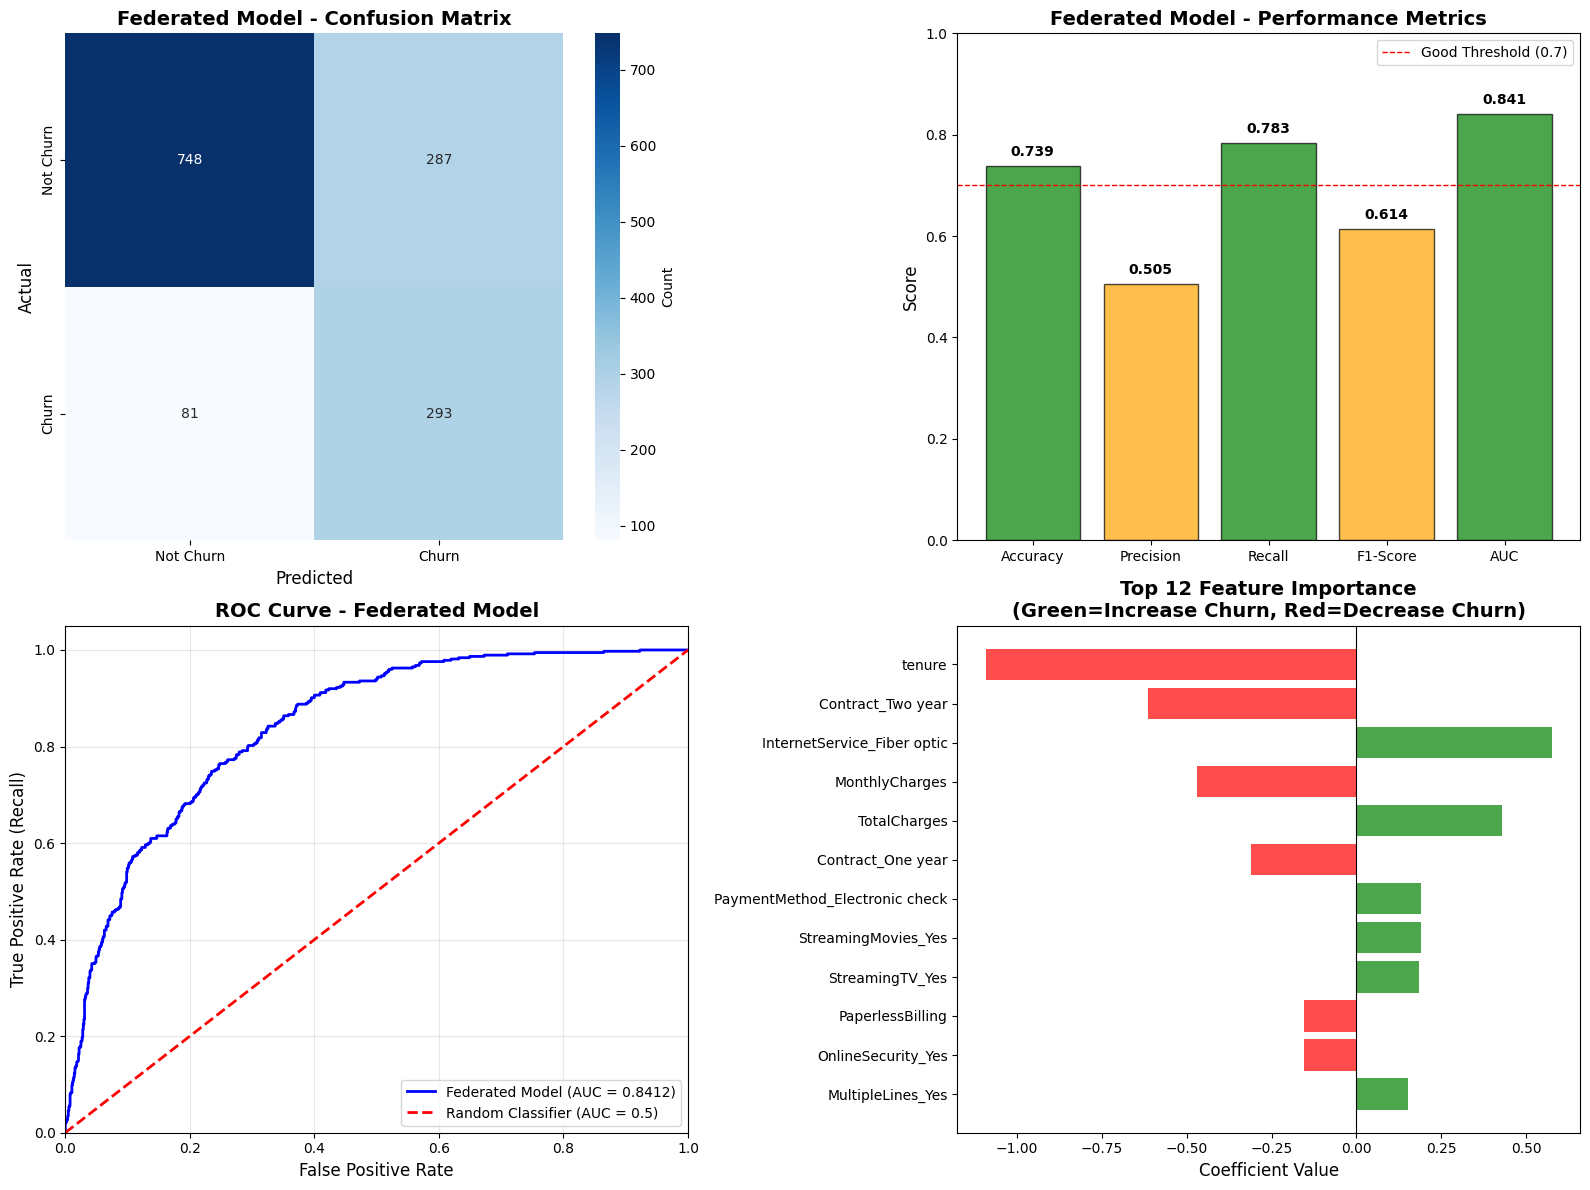


✓ Visualization saved as: federated_model_evaluation.png

COMPARISON: FEDERATED vs INDIVIDUAL CLIENT MODELS

                 Model  Accuracy  Precision   Recall  F1-Score      AUC
Federated (Aggregated)  0.738822   0.505172 0.783422  0.614256 0.841161
      Client 0 (Local)  0.723918   0.487923 0.810160  0.609045 0.834070
      Client 1 (Local)  0.740241   0.507143 0.759358  0.608137 0.839619
      Client 2 (Local)  0.733854   0.499148 0.783422  0.609781 0.837859

📊 Federated model improves average local model accuracy by: 0.84%

SAVING MODELS AND RESULTS
✓ Complete model package saved to: federated_learning_complete.pkl
✓ Comparison results saved to: federated_vs_local_comparison.csv
✓ Feature importance saved to: federated_feature_importance.csv
✓ Summary metrics saved to: federated_model_summary.csv

✅ FEDERATED LEARNING PHASE COMPLETE!

📊 Final Federated Model Performance:
   • Accuracy: 0.7388
   • Recall: 0.7834
   • AUC: 0.8412

💾 All models and results saved successfully!

🎯 

In [36]:
import pickle
from sklearn.metrics import confusion_matrix, classification_report

print("="*70)
print("COMPREHENSIVE FEDERATED MODEL EVALUATION")
print("="*70)

# ============================================================
# 1. PREDICTIONS
# ============================================================
y_pred_fed = global_federated_model.predict(X_test_scaled_global)
y_pred_proba_fed = global_federated_model.predict_proba(X_test_scaled_global)[:, 1]

# ============================================================
# 2. BASIC METRICS
# ============================================================
fed_accuracy = accuracy_score(y_test_global, y_pred_fed)
fed_precision = precision_score(y_test_global, y_pred_fed)
fed_recall = recall_score(y_test_global, y_pred_fed)
fed_f1 = f1_score(y_test_global, y_pred_fed)
fed_auc = roc_auc_score(y_test_global, y_pred_proba_fed)

print("\n" + "="*70)
print("FEDERATED MODEL PERFORMANCE METRICS")
print("="*70)
print(f"Accuracy:  {fed_accuracy:.4f} ({fed_accuracy*100:.2f}%)")
print(f"Precision: {fed_precision:.4f} ({fed_precision*100:.2f}%)")
print(f"Recall:    {fed_recall:.4f} ({fed_recall*100:.2f}%)")
print(f"F1-Score:  {fed_f1:.4f} ({fed_f1*100:.2f}%)")
print(f"ROC-AUC:   {fed_auc:.4f} ({fed_auc*100:.2f}%)")

# ============================================================
# 3. CONFUSION MATRIX
# ============================================================
cm_fed = confusion_matrix(y_test_global, y_pred_fed)
tn, fp, fn, tp = cm_fed.ravel()

print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)
print(cm_fed)
print(f"\nTrue Positives (Correctly predicted churners):  {tp}")
print(f"True Negatives (Correctly predicted stayed):    {tn}")
print(f"False Positives (Predicted churn, but stayed):  {fp}")
print(f"False Negatives (Missed churners):              {fn}")

# ============================================================
# 4. DETAILED CLASSIFICATION REPORT
# ============================================================
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test_global, y_pred_fed,
                          target_names=['Not Churn', 'Churn'],
                          digits=4))

# ============================================================
# 5. BUSINESS INSIGHTS
# ============================================================
total_actual_churners = tp + fn
total_predicted_churners = tp + fp
catch_rate = tp / total_actual_churners * 100
miss_rate = fn / total_actual_churners * 100
false_alarm_rate = fp / (fp + tn) * 100

print("\n" + "="*70)
print("BUSINESS INSIGHTS")
print("="*70)
print(f"Total test customers: {len(y_test_global)}")
print(f"\nChurn Detection Performance:")
print(f"  • Total actual churners: {total_actual_churners}")
print(f"  • Correctly identified: {tp} ({catch_rate:.1f}% catch rate)")
print(f"  • Missed churners: {fn} ({miss_rate:.1f}% miss rate)")
print(f"\nFalse Alarms:")
print(f"  • Predicted to churn but stayed: {fp}")
print(f"  • False alarm rate: {false_alarm_rate:.1f}%")
print(f"\nCustomers Correctly Identified as Staying: {tn}")

# ============================================================
# 6. COST-BENEFIT ANALYSIS
# ============================================================
# Assume: Lost customer = $500, Retention offer = $50
cost_per_lost_customer = 500
cost_per_retention_offer = 50

cost_missed_churners = fn * cost_per_lost_customer
cost_false_alarms = fp * cost_per_retention_offer
total_cost = cost_missed_churners + cost_false_alarms

# Calculate if we did nothing
cost_do_nothing = total_actual_churners * cost_per_lost_customer

savings = cost_do_nothing - total_cost
roi = (savings / total_cost) * 100 if total_cost > 0 else 0

print("\n" + "="*70)
print("COST-BENEFIT ANALYSIS")
print("="*70)
print(f"Assumptions:")
print(f"  • Lost customer cost: ${cost_per_lost_customer}")
print(f"  • Retention offer cost: ${cost_per_retention_offer}")
print(f"\nCosts with Federated Model:")
print(f"  • Missed churners cost: ${cost_missed_churners:,} ({fn} customers)")
print(f"  • False alarms cost: ${cost_false_alarms:,} ({fp} customers)")
print(f"  • Total cost: ${total_cost:,}")
print(f"\nWithout Model (Do Nothing):")
print(f"  • Total cost: ${cost_do_nothing:,}")
print(f"\nSavings: ${savings:,}")
print(f"ROI: {roi:.1f}%")

# ============================================================
# 7. MODEL COEFFICIENTS ANALYSIS
# ============================================================
feature_importance_fed = pd.DataFrame({
    'Feature': X_test_global.columns,
    'Coefficient': global_federated_model.coef_[0]
})
feature_importance_fed['Abs_Coefficient'] = abs(feature_importance_fed['Coefficient'])
feature_importance_fed = feature_importance_fed.sort_values('Abs_Coefficient', ascending=False)

print("\n" + "="*70)
print("TOP 10 MOST IMPORTANT FEATURES (Federated Model)")
print("="*70)
print(feature_importance_fed[['Feature', 'Coefficient']].head(10).to_string(index=False))

# ============================================================
# 8. VISUALIZATIONS
# ============================================================

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 8.1 Confusion Matrix Heatmap
sns.heatmap(cm_fed, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'],
            cbar_kws={'label': 'Count'})
axes[0, 0].set_title('Federated Model - Confusion Matrix', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Actual', fontsize=12)
axes[0, 0].set_xlabel('Predicted', fontsize=12)

# 8.2 Metrics Bar Chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [fed_accuracy, fed_precision, fed_recall, fed_f1, fed_auc]
colors_metric = ['green' if v >= 0.7 else 'orange' for v in metrics_values]

axes[0, 1].bar(metrics_names, metrics_values, color=colors_metric, alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Score', fontsize=12)
axes[0, 1].set_title('Federated Model - Performance Metrics', fontsize=14, fontweight='bold')
axes[0, 1].set_ylim([0, 1.0])
axes[0, 1].axhline(y=0.7, color='red', linestyle='--', linewidth=1, label='Good Threshold (0.7)')
axes[0, 1].legend()
for i, v in enumerate(metrics_values):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# 8.3 ROC Curve
from sklearn.metrics import roc_curve
fpr_fed, tpr_fed, thresholds_fed = roc_curve(y_test_global, y_pred_proba_fed)

axes[1, 0].plot(fpr_fed, tpr_fed, color='blue', lw=2,
                label=f'Federated Model (AUC = {fed_auc:.4f})')
axes[1, 0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--',
                label='Random Classifier (AUC = 0.5)')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[1, 0].set_ylabel('True Positive Rate (Recall)', fontsize=12)
axes[1, 0].set_title('ROC Curve - Federated Model', fontsize=14, fontweight='bold')
axes[1, 0].legend(loc="lower right")
axes[1, 0].grid(alpha=0.3)

# 8.4 Feature Importance
top_features = feature_importance_fed.head(12)
colors_feat = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
axes[1, 1].barh(top_features['Feature'], top_features['Coefficient'], color=colors_feat, alpha=0.7)
axes[1, 1].set_xlabel('Coefficient Value', fontsize=12)
axes[1, 1].set_title('Top 12 Feature Importance\n(Green=Increase Churn, Red=Decrease Churn)',
                     fontsize=14, fontweight='bold')
axes[1, 1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('federated_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as: federated_model_evaluation.png")

# ============================================================
# 9. COMPARISON WITH LOCAL MODELS
# ============================================================
print("\n" + "="*70)
print("COMPARISON: FEDERATED vs INDIVIDUAL CLIENT MODELS")
print("="*70)

comparison_data = []

# Federated model
comparison_data.append({
    'Model': 'Federated (Aggregated)',
    'Accuracy': fed_accuracy,
    'Precision': fed_precision,
    'Recall': fed_recall,
    'F1-Score': fed_f1,
    'AUC': fed_auc
})

# Individual client models
for i, model in enumerate(local_models):
    y_pred_local = model.predict(X_test_scaled_global)
    y_pred_proba_local = model.predict_proba(X_test_scaled_global)[:, 1]

    comparison_data.append({
        'Model': f'Client {i} (Local)',
        'Accuracy': accuracy_score(y_test_global, y_pred_local),
        'Precision': precision_score(y_test_global, y_pred_local),
        'Recall': recall_score(y_test_global, y_pred_local),
        'F1-Score': f1_score(y_test_global, y_pred_local),
        'AUC': roc_auc_score(y_test_global, y_pred_proba_local)
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Calculate improvement
avg_local_accuracy = comparison_df[comparison_df['Model'].str.contains('Local')]['Accuracy'].mean()
improvement = ((fed_accuracy - avg_local_accuracy) / avg_local_accuracy) * 100

print(f"\n📊 Federated model improves average local model accuracy by: {improvement:.2f}%")

# ============================================================
# 10. SAVE MODELS AND RESULTS
# ============================================================
print("\n" + "="*70)
print("SAVING MODELS AND RESULTS")
print("="*70)

# Prepare comprehensive save package
save_package = {
    'federated_model': global_federated_model,
    'local_models': local_models,
    'scalers': {
        'test_scaler': test_scaler,
        'client_scalers': scalers
    },
    'metrics': {
        'accuracy': fed_accuracy,
        'precision': fed_precision,
        'recall': fed_recall,
        'f1_score': fed_f1,
        'auc': fed_auc
    },
    'confusion_matrix': {
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp)
    },
    'feature_importance': feature_importance_fed.to_dict('records'),
    'comparison_results': comparison_df.to_dict('records'),
    'client_info': {
        'n_clients': len(clients),
        'client_sizes': [len(c['y']) for c in clients],
        'client_weights': client_weights
    }
}

# Save to pickle
with open('federated_learning_complete.pkl', 'wb') as f:
    pickle.dump(save_package, f)

print("✓ Complete model package saved to: federated_learning_complete.pkl")

# Save comparison results to CSV
comparison_df.to_csv('federated_vs_local_comparison.csv', index=False)
print("✓ Comparison results saved to: federated_vs_local_comparison.csv")

# Save feature importance
feature_importance_fed.to_csv('federated_feature_importance.csv', index=False)
print("✓ Feature importance saved to: federated_feature_importance.csv")

# Save detailed metrics summary
summary_dict = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC',
               'True Positives', 'True Negatives', 'False Positives', 'False Negatives',
               'Catch Rate (%)', 'Miss Rate (%)', 'Total Cost ($)', 'Savings ($)', 'ROI (%)'],
    'Value': [
        f"{fed_accuracy:.4f}",
        f"{fed_precision:.4f}",
        f"{fed_recall:.4f}",
        f"{fed_f1:.4f}",
        f"{fed_auc:.4f}",
        str(tp),
        str(tn),
        str(fp),
        str(fn),
        f"{catch_rate:.2f}",
        f"{miss_rate:.2f}",
        f"{total_cost:,.0f}",
        f"{savings:,.0f}",
        f"{roi:.2f}"
    ]
}
summary_df = pd.DataFrame(summary_dict)
summary_df.to_csv('federated_model_summary.csv', index=False)
print("✓ Summary metrics saved to: federated_model_summary.csv")

print("\n" + "="*70)
print("✅ FEDERATED LEARNING PHASE COMPLETE!")
print("="*70)
print(f"\n📊 Final Federated Model Performance:")
print(f"   • Accuracy: {fed_accuracy:.4f}")
print(f"   • Recall: {fed_recall:.4f}")
print(f"   • AUC: {fed_auc:.4f}")
print(f"\n💾 All models and results saved successfully!")
print(f"\n🎯 Key Achievement:")
print(f"   Privacy-preserving federated learning achieved {fed_accuracy*100:.1f}% accuracy")
print(f"   while catching {catch_rate:.1f}% of churners WITHOUT sharing raw customer data!")